<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.shape

(1460, 81)

In [4]:
house.dtypes


Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [5]:
null_columns=house.columns[house.isnull().any()]
house[null_columns].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [6]:
#Replace null values in lotfrontage

house.LotFrontage.fillna(0, inplace = True)

In [7]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
# A:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
house.TotRmsAbvGrd.value_counts(dropna=False)

6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64

In [10]:
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [11]:
# Droping all rows where property is not residential
house = house[house.MSZoning !='C (all)']

In [12]:
house['MSZoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

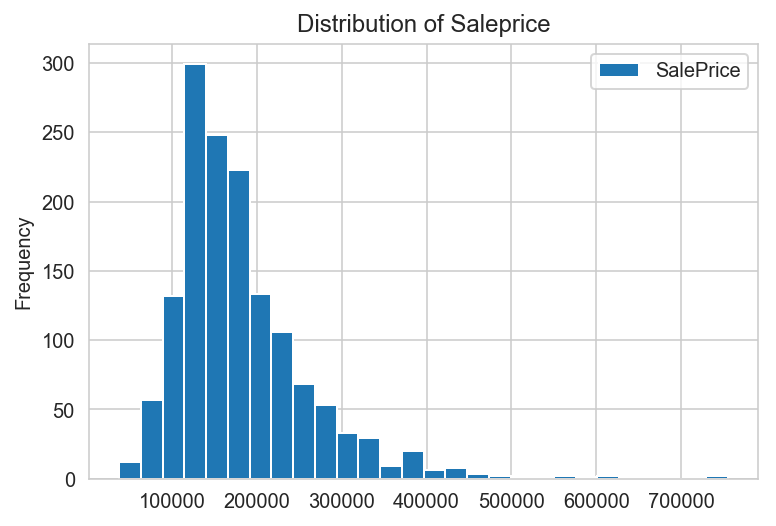

In [13]:
house[['SalePrice']].plot.hist(stacked=True, bins=28,)
plt.title('Distribution of Saleprice')
plt.show()

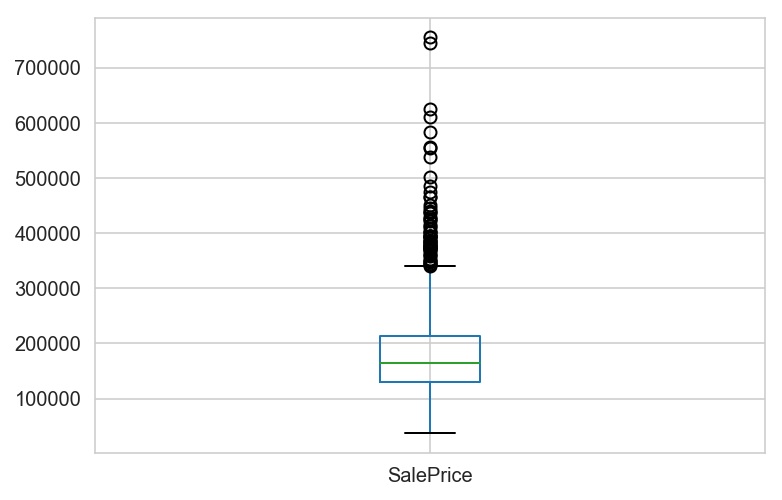

In [14]:
house[['SalePrice']].boxplot()

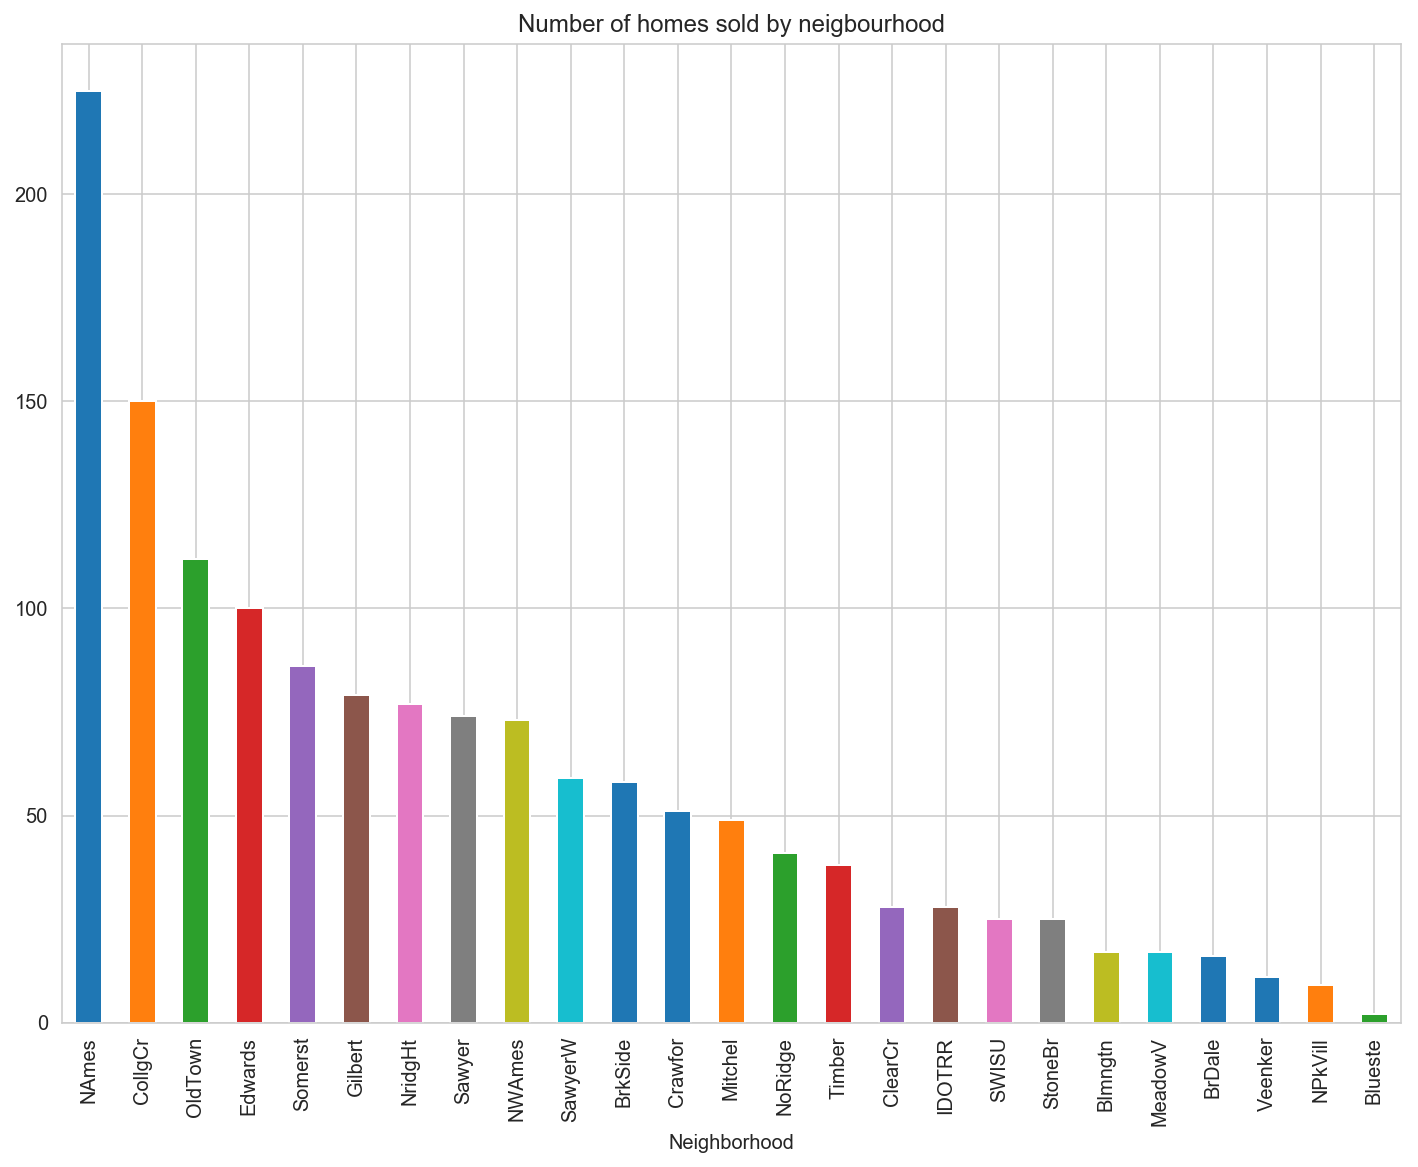

In [15]:
#Setting up the plotting area size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
######################################################################

house.groupby(["Neighborhood"]).size().sort_values(ascending=False).plot(kind='bar')
plt.title('Number of homes sold by neigbourhood')
plt.show()

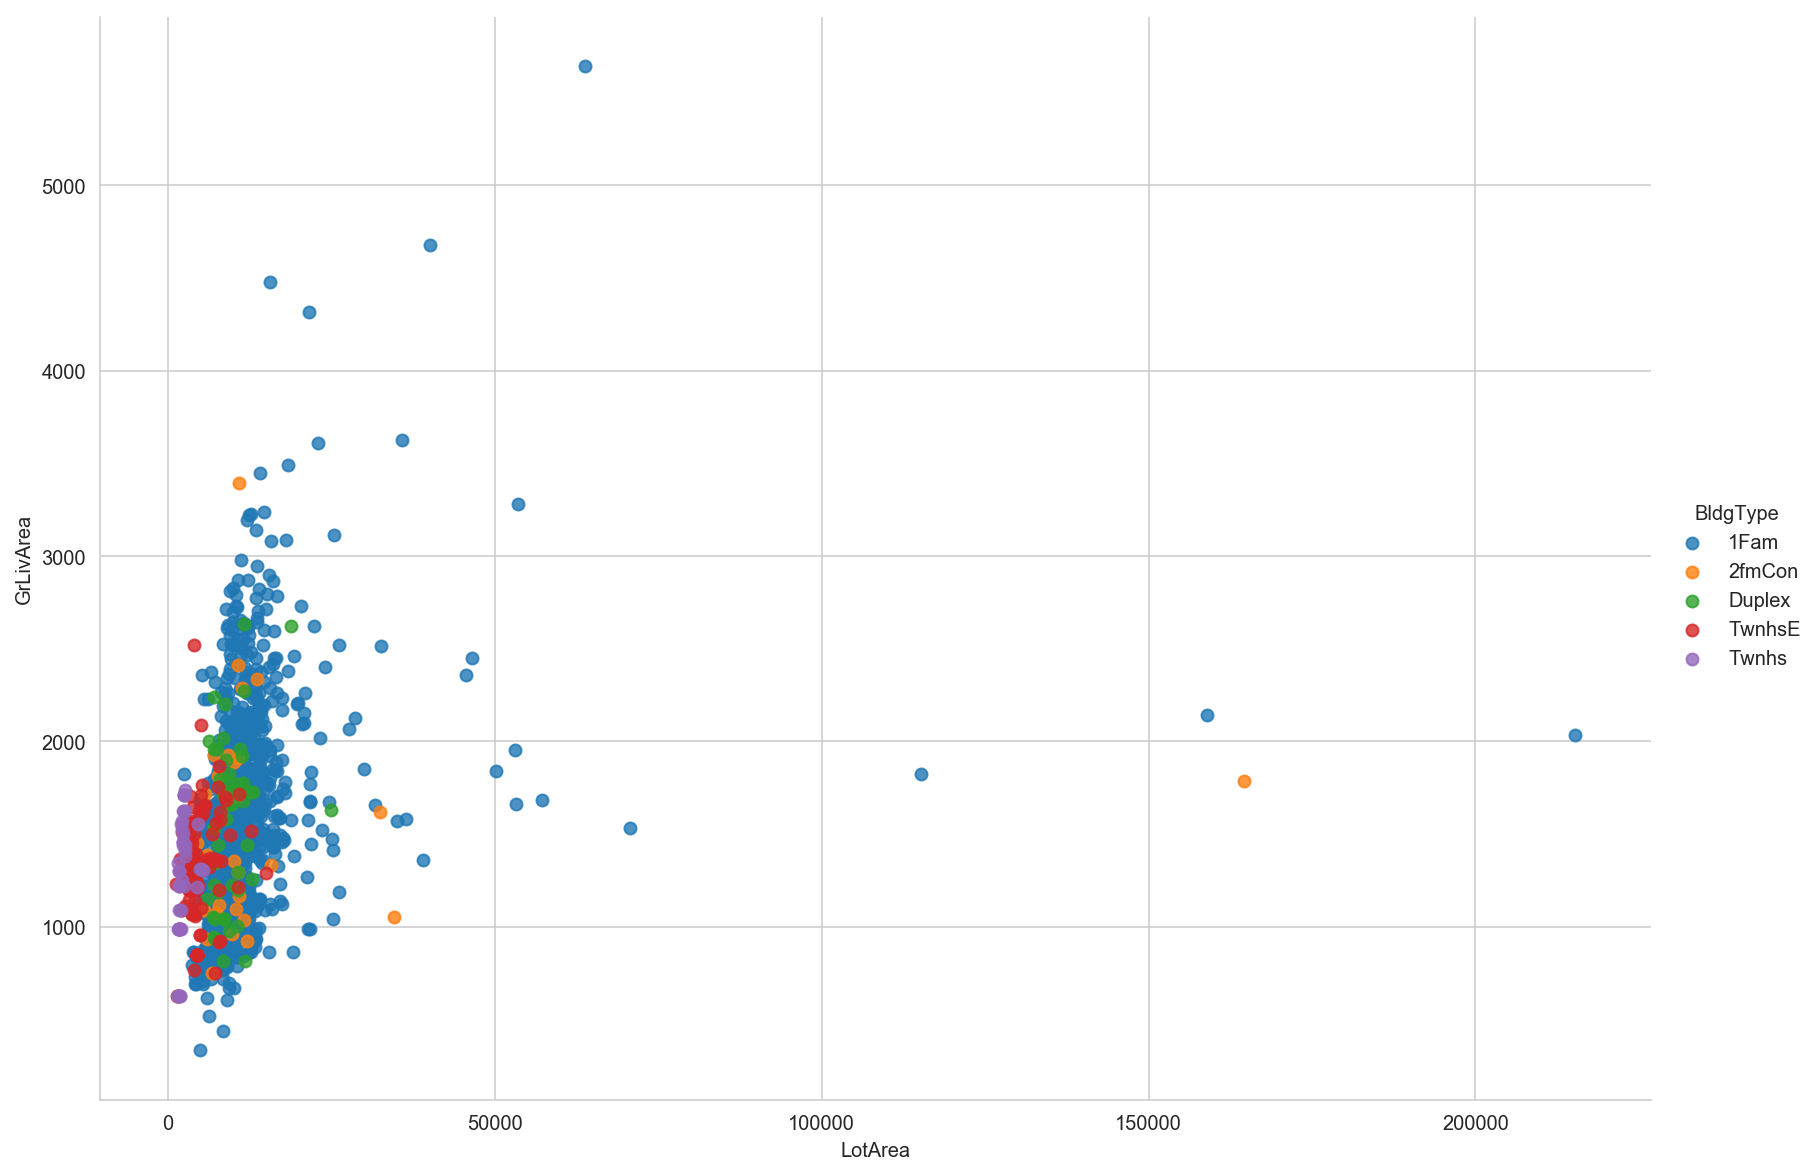

In [16]:
g = sns.lmplot(x='LotArea', y="GrLivArea", data=house,hue='BldgType',fit_reg=False,height=8.27, aspect=11.7/8.27)


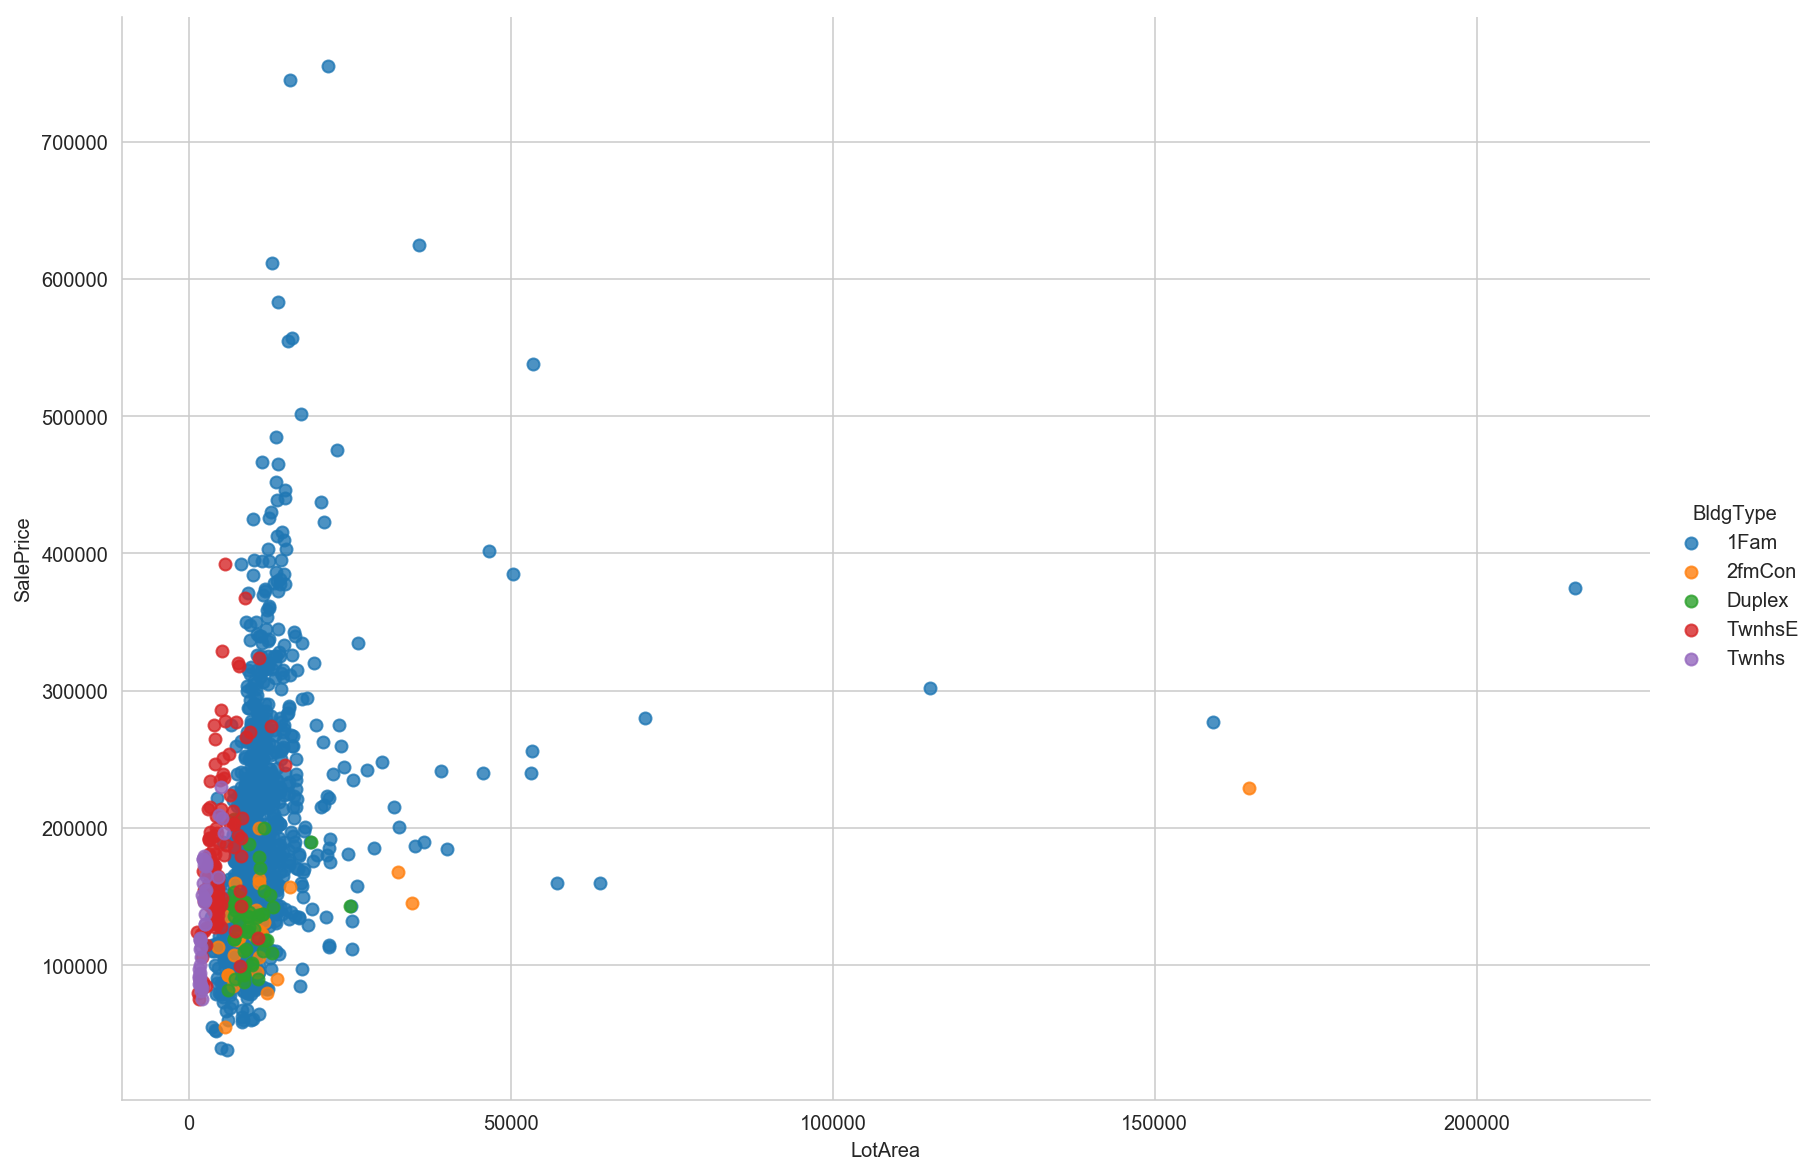

In [17]:
sns.lmplot(x='LotArea', y="SalePrice", data=house,hue='BldgType',fit_reg=False,height=8.27, aspect=11.7/8.27)
plt.show()

In [18]:
# The two plot above look quite similar, Saleprice and GrLiveAr densely located upto 25k to 30k

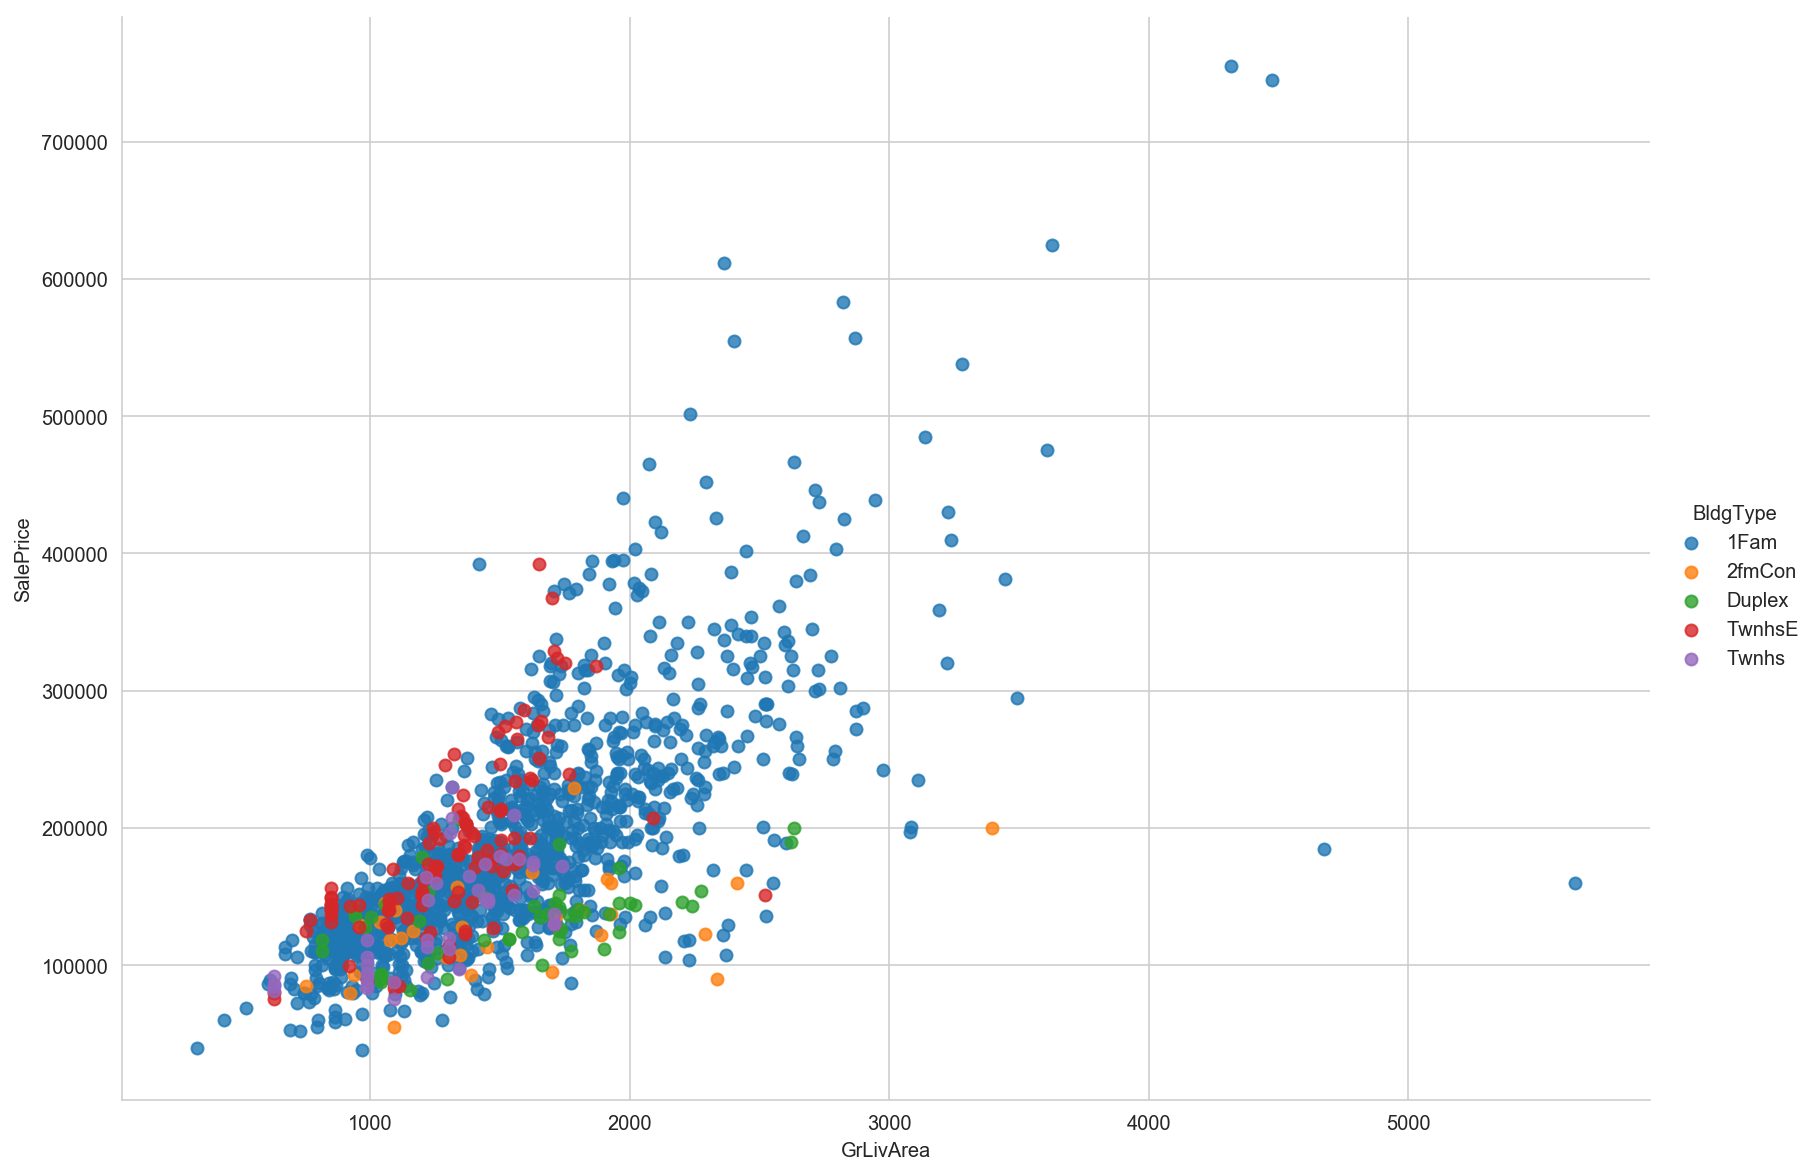

In [19]:
g = sns.lmplot(x='GrLivArea', y="SalePrice", data=house,hue='BldgType',fit_reg=False,height=8.27, aspect=11.7/8.27)

In [20]:
#Very strong relation between GrLivArea and SalePrice

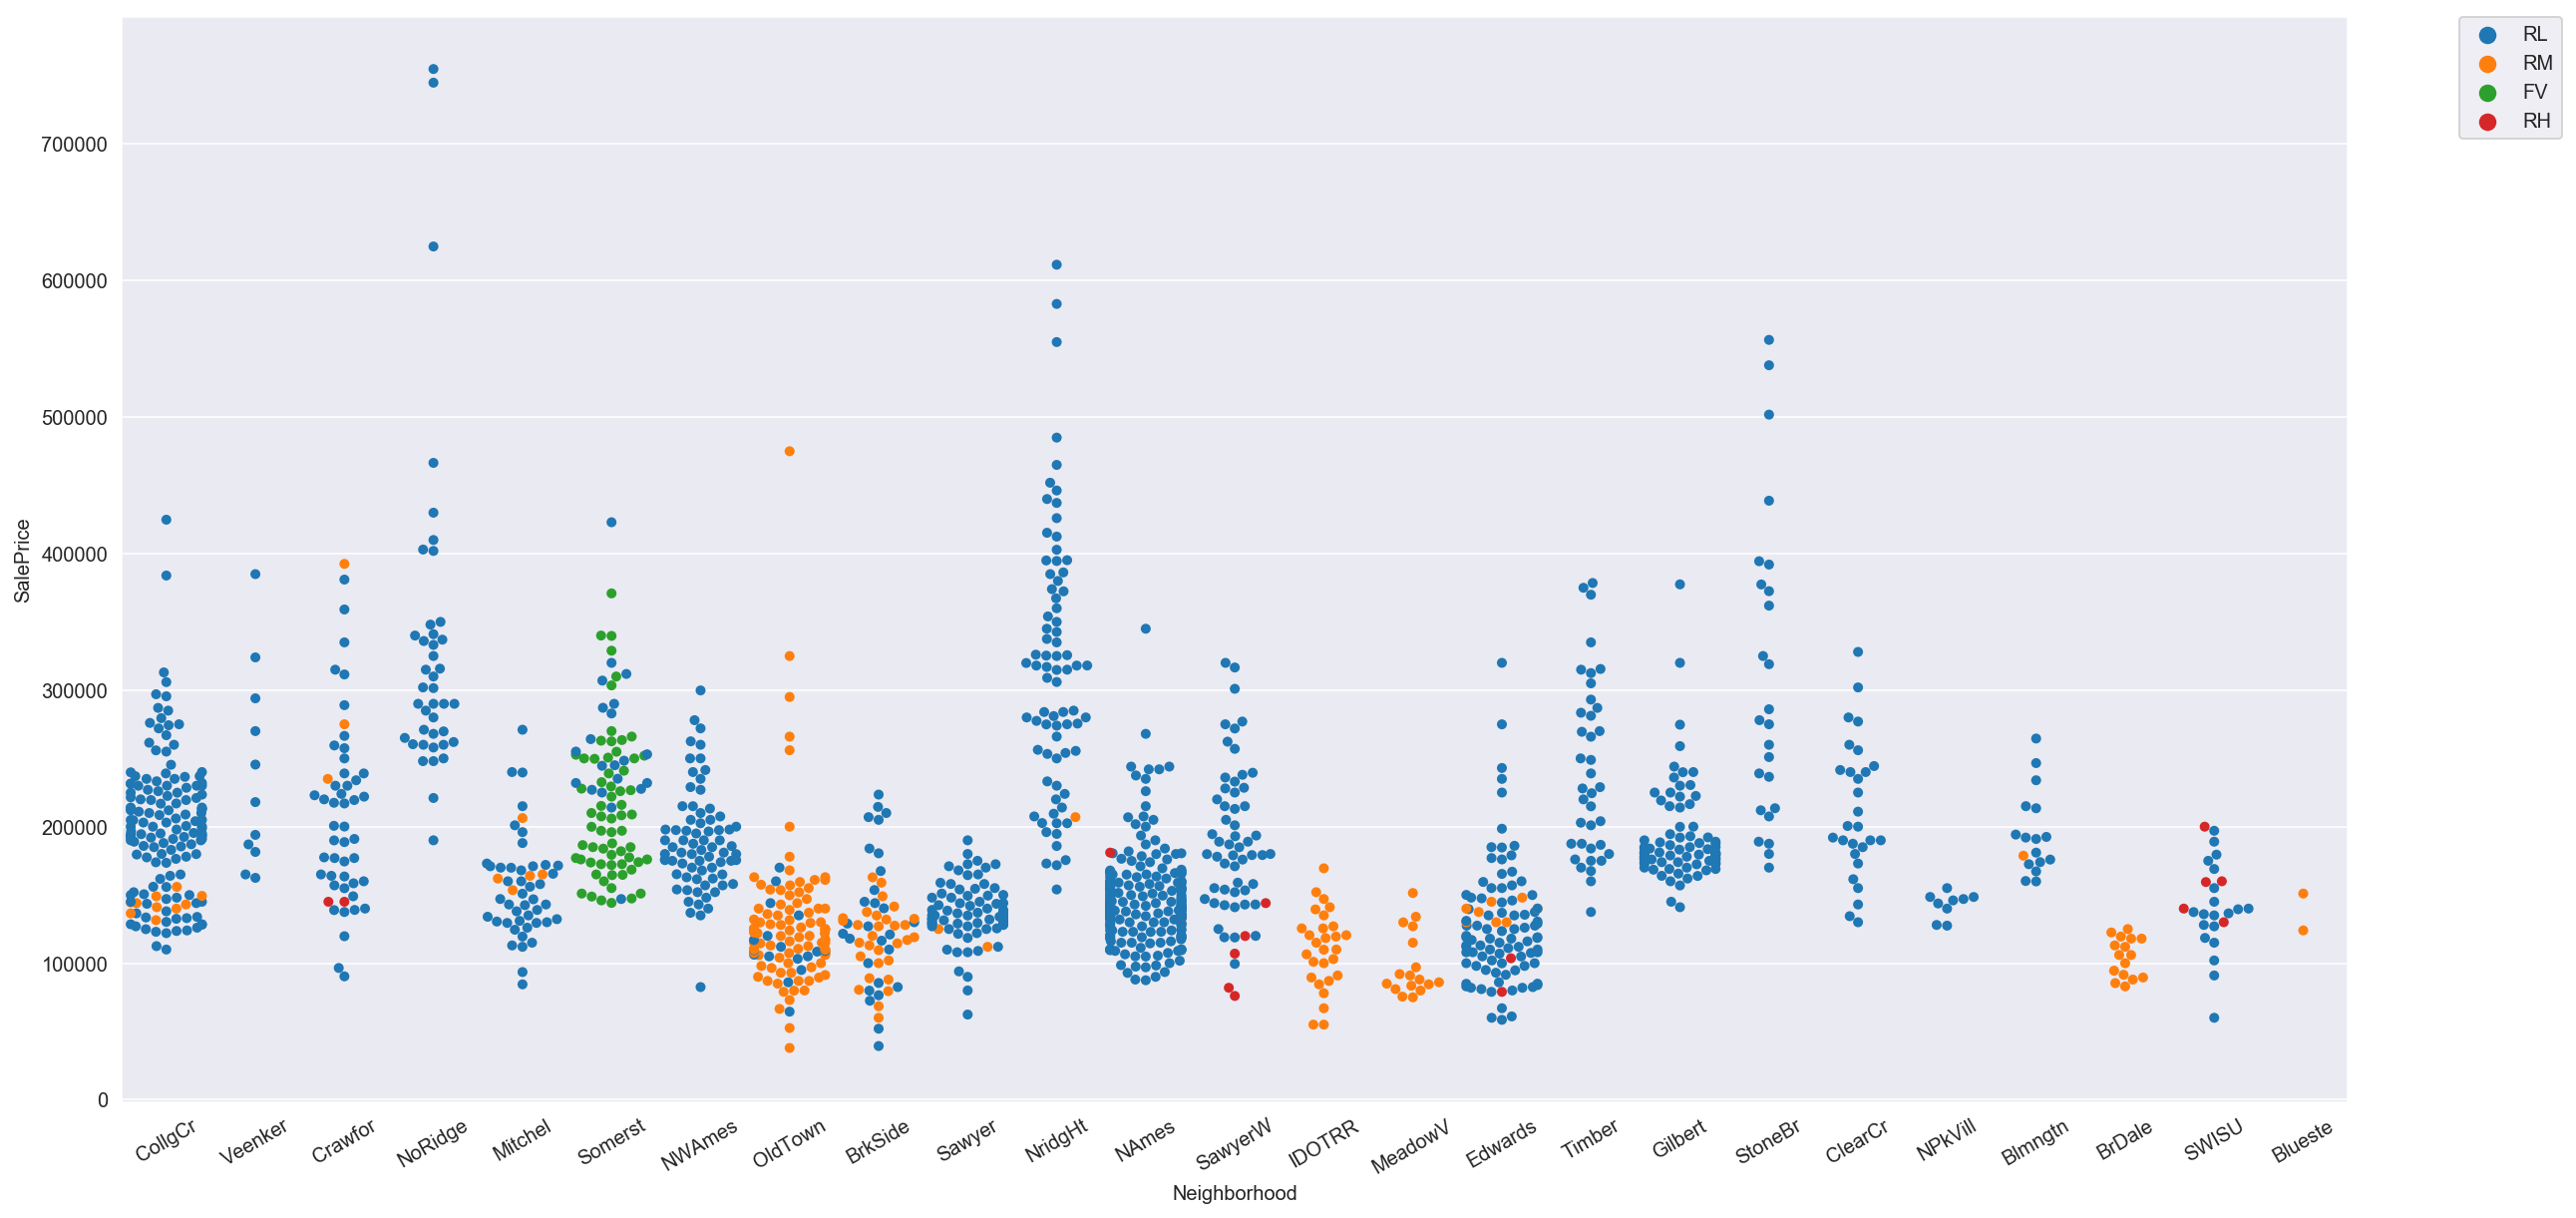

In [21]:
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
sns.swarmplot(x=house['Neighborhood'],y=house['SalePrice'],hue=house['MSZoning'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30)
plt.show()

No handles with labels found to put in legend.


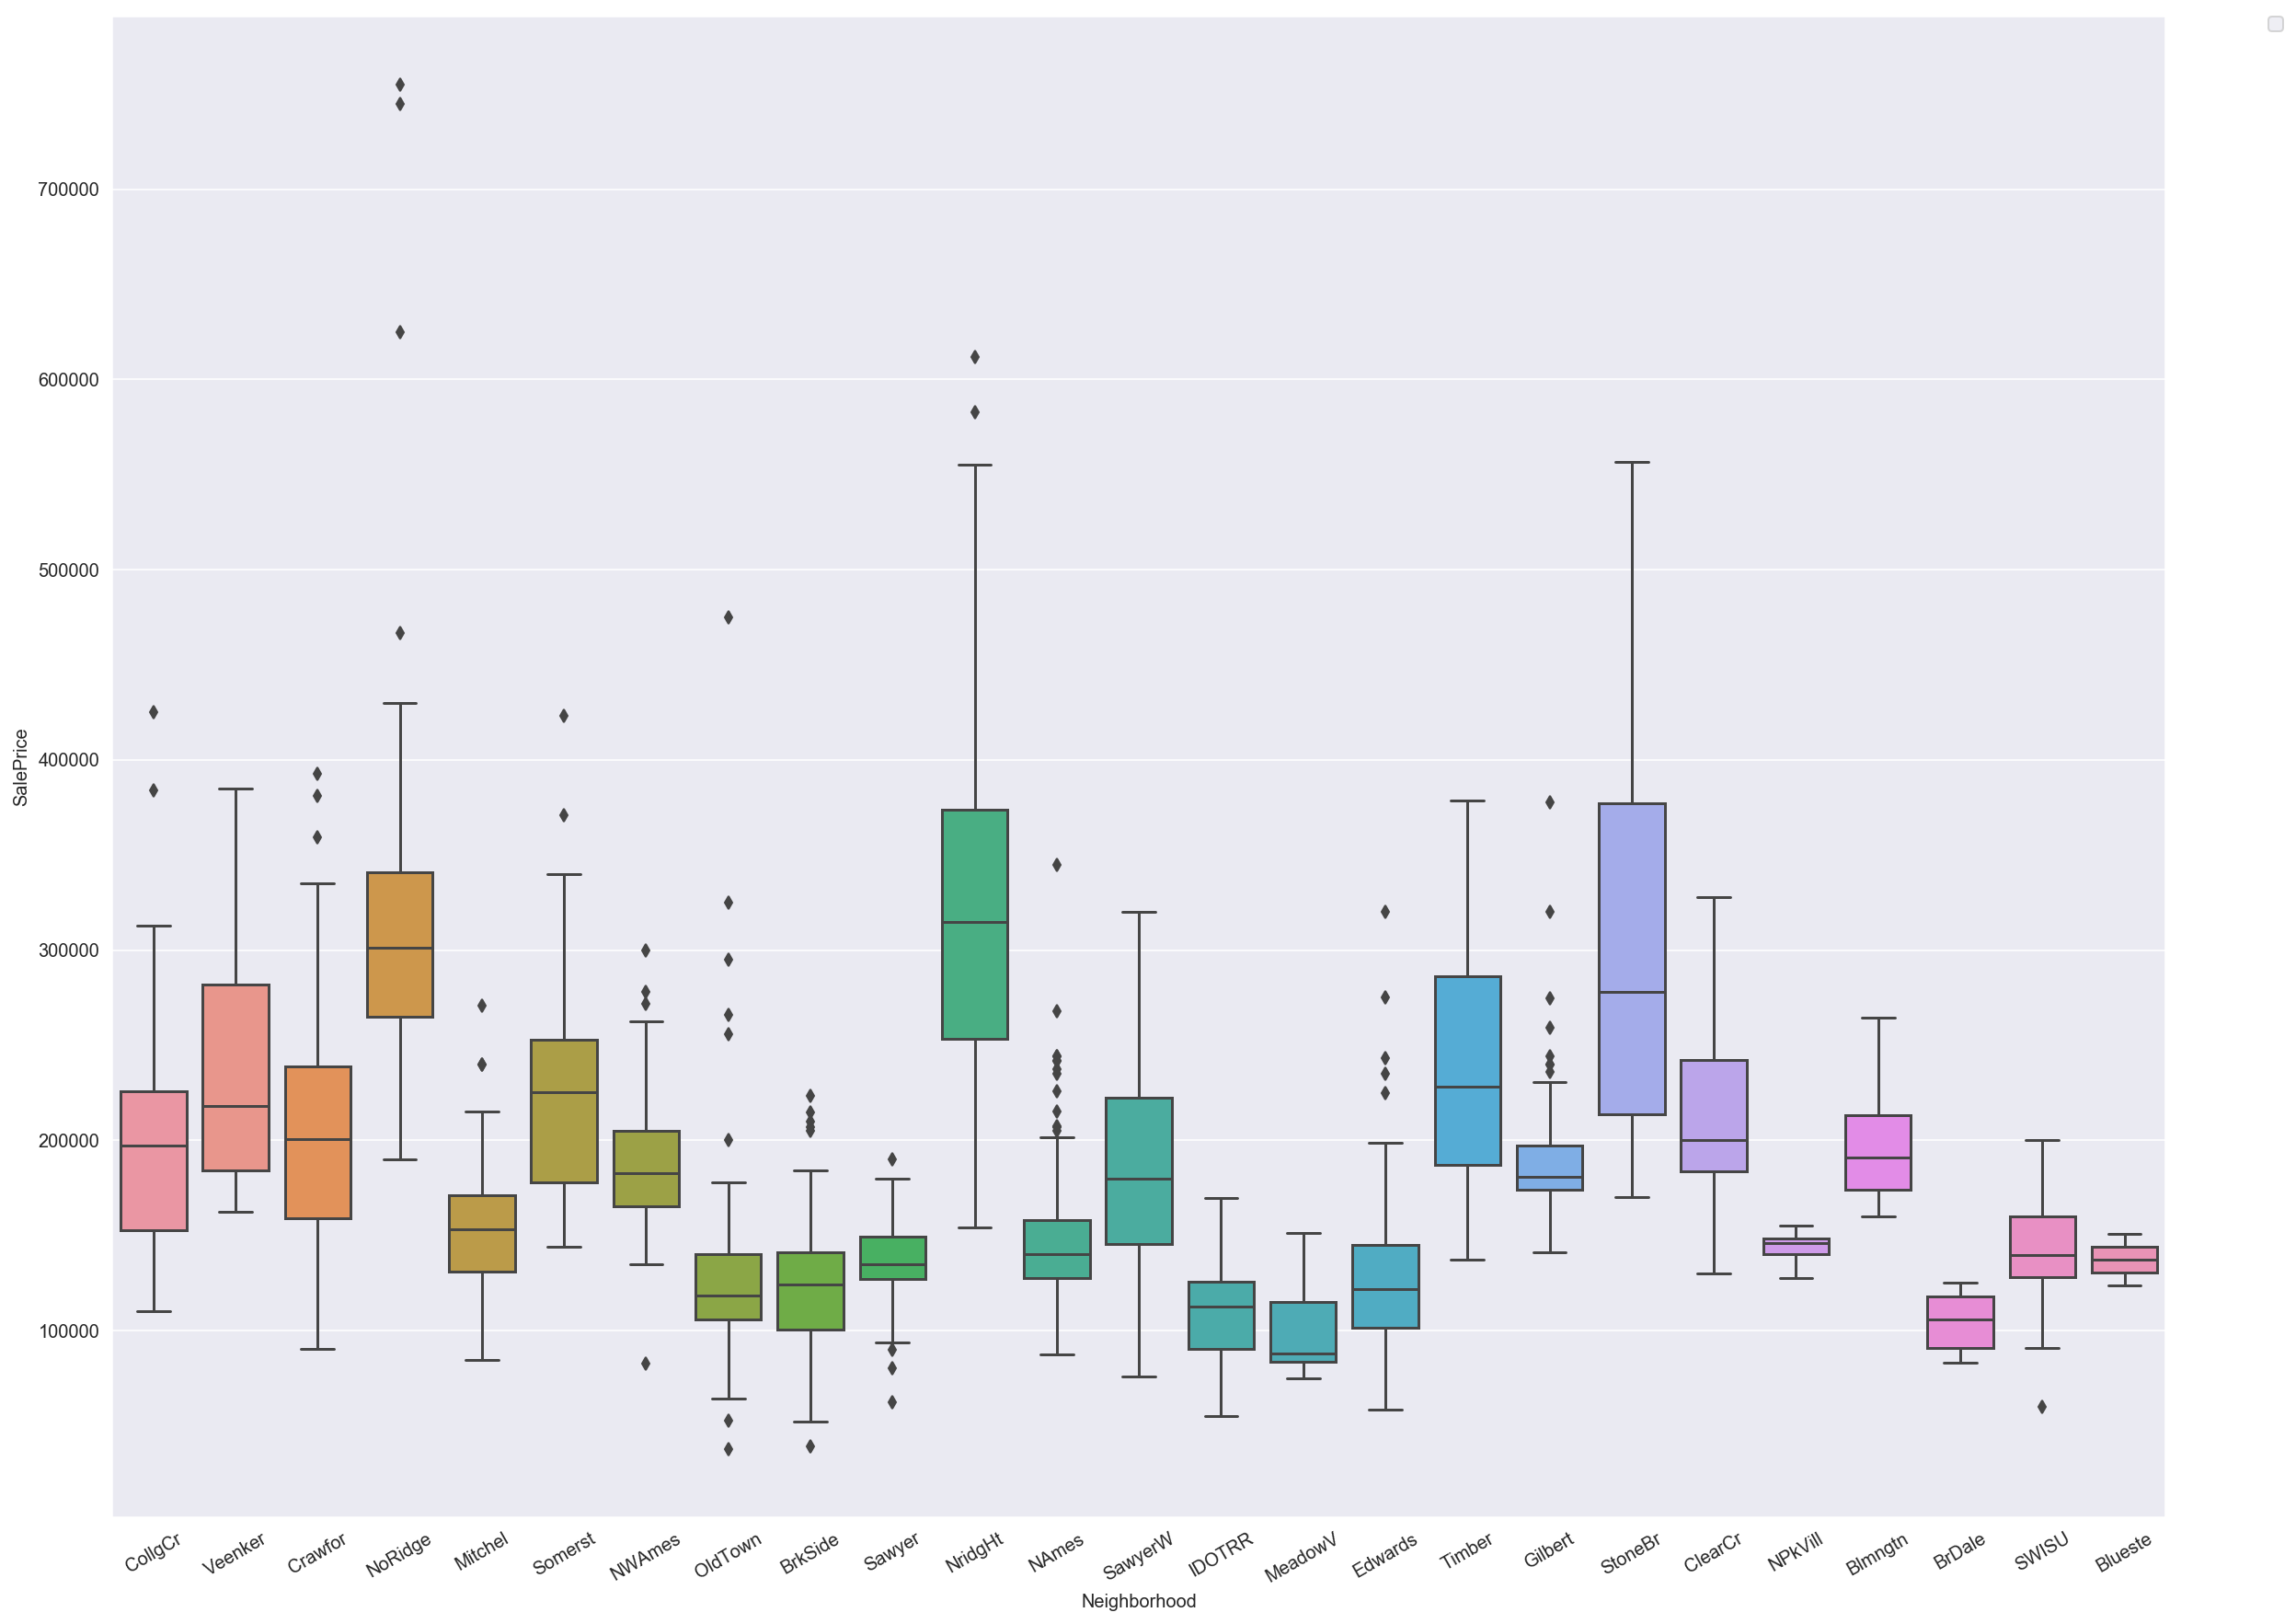

In [22]:
plt.figure(figsize=(20,15))
sns.set_style('darkgrid')
sns.boxplot(x=house['Neighborhood'],y=house['SalePrice'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

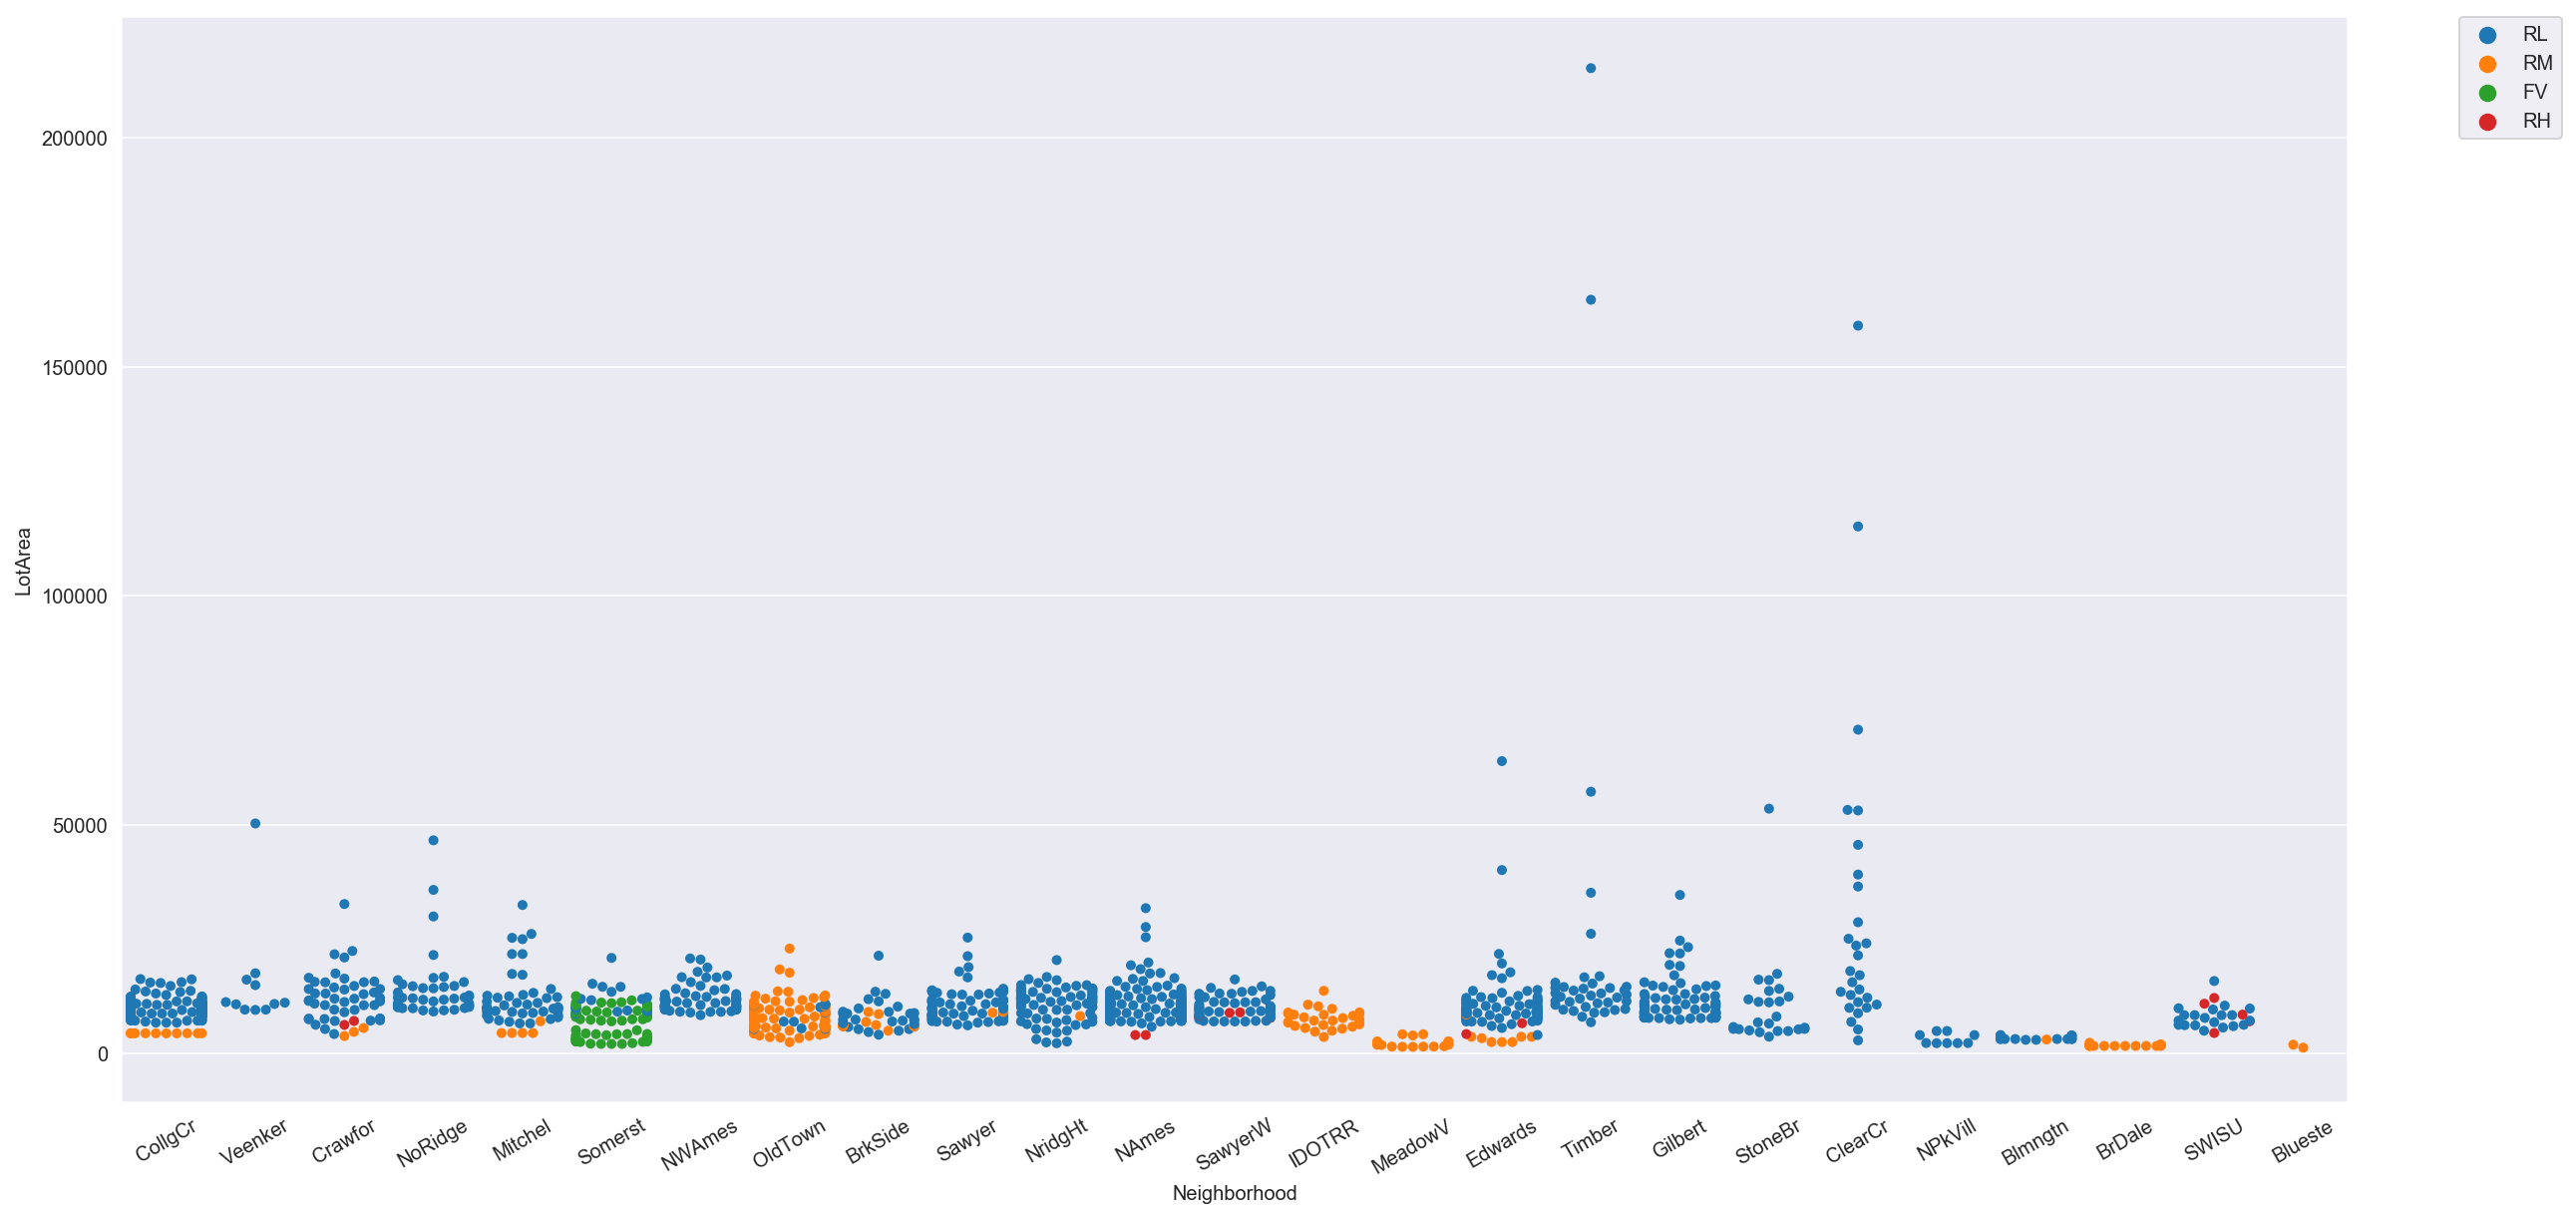

In [23]:
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
sns.swarmplot(x=house['Neighborhood'],y=house['LotArea'],hue=house['MSZoning'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30)

In [24]:
#I wanted to check if 1st, 2nd,LowQual floor area would sum up to GrLivArea
house[['1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea']].head()

,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea
0,856,854,0,1710
1,1262,0,0,1262
2,920,866,0,1786
3,961,756,0,1717
4,1145,1053,0,2198


In [25]:
# Initial look would suggest so. Lets just make sure

In [26]:
house.loc[house['1stFlrSF']+house['2ndFlrSF']+house['LowQualFinSF']!= house['GrLivArea']].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [27]:
#This confirms it, so I move forward not including the three in the model

## Setting up for fixed features based model

In [28]:
fixed_house=house[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea','LotShape', 'LandContour','BldgType',
                   'HouseStyle','TotalBsmtSF','GarageArea','GrLivArea','FullBath','Foundation',
                   'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd','GarageCars','WoodDeckSF', 'OpenPorchSF',
                   'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','MiscVal','YearBuilt','YrSold', 'SaleType',
                   'SaleCondition', 'SalePrice']]
fixed_house.shape

(1450, 30)

In [29]:
fixed_house.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
LotShape          object
LandContour       object
BldgType          object
HouseStyle        object
TotalBsmtSF        int64
GarageArea         int64
GrLivArea          int64
FullBath           int64
Foundation        object
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
GarageCars         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
YearBuilt          int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
dtype: object

In [30]:
fixed_house.describe()

,MSSubClass,LotFrontage,LotArea,TotalBsmtSF,GarageArea,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YearBuilt,YrSold,SalePrice
count,1450.000000,1450.00000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,56.903448,57.54000,10523.831724,1059.408966,473.277931,1517.698621,1.568966,0.384828,2.870345,1.046207,...,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,1971.593103,2007.812414,181654.942069
std,42.265033,34.71992,10012.185355,439.207322,212.687621,525.154207,0.549549,0.503450,0.814645,0.219643,...,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,30.022696,1.326321,79176.485241
min,20.000000,0.00000,1300.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1872.000000,2006.000000,37900.000000
25%,20.000000,41.25000,7544.500000,796.000000,336.000000,1131.250000,1.000000,0.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1954.000000,2007.000000,130000.000000
50%,50.000000,63.00000,9496.000000,992.000000,480.000000,1466.000000,2.000000,0.000000,3.000000,1.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1973.000000,2008.000000,163945.000000
75%,70.000000,79.00000,11613.500000,1301.500000,576.000000,1779.000000,2.000000,1.000000,3.000000,1.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2001.000000,2009.000000,214000.000000
max,190.000000,313.00000,215245.000000,6110.000000,1418.000000,5642.000000,3.000000,2.000000,8.000000,3.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,2010.000000,2010.000000,755000.000000


In [31]:
fixed_house.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
LotShape         0
LandContour      0
BldgType         0
HouseStyle       0
TotalBsmtSF      0
GarageArea       0
GrLivArea        0
FullBath         0
Foundation       0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
GarageCars       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
YearBuilt        0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
dtype: int64

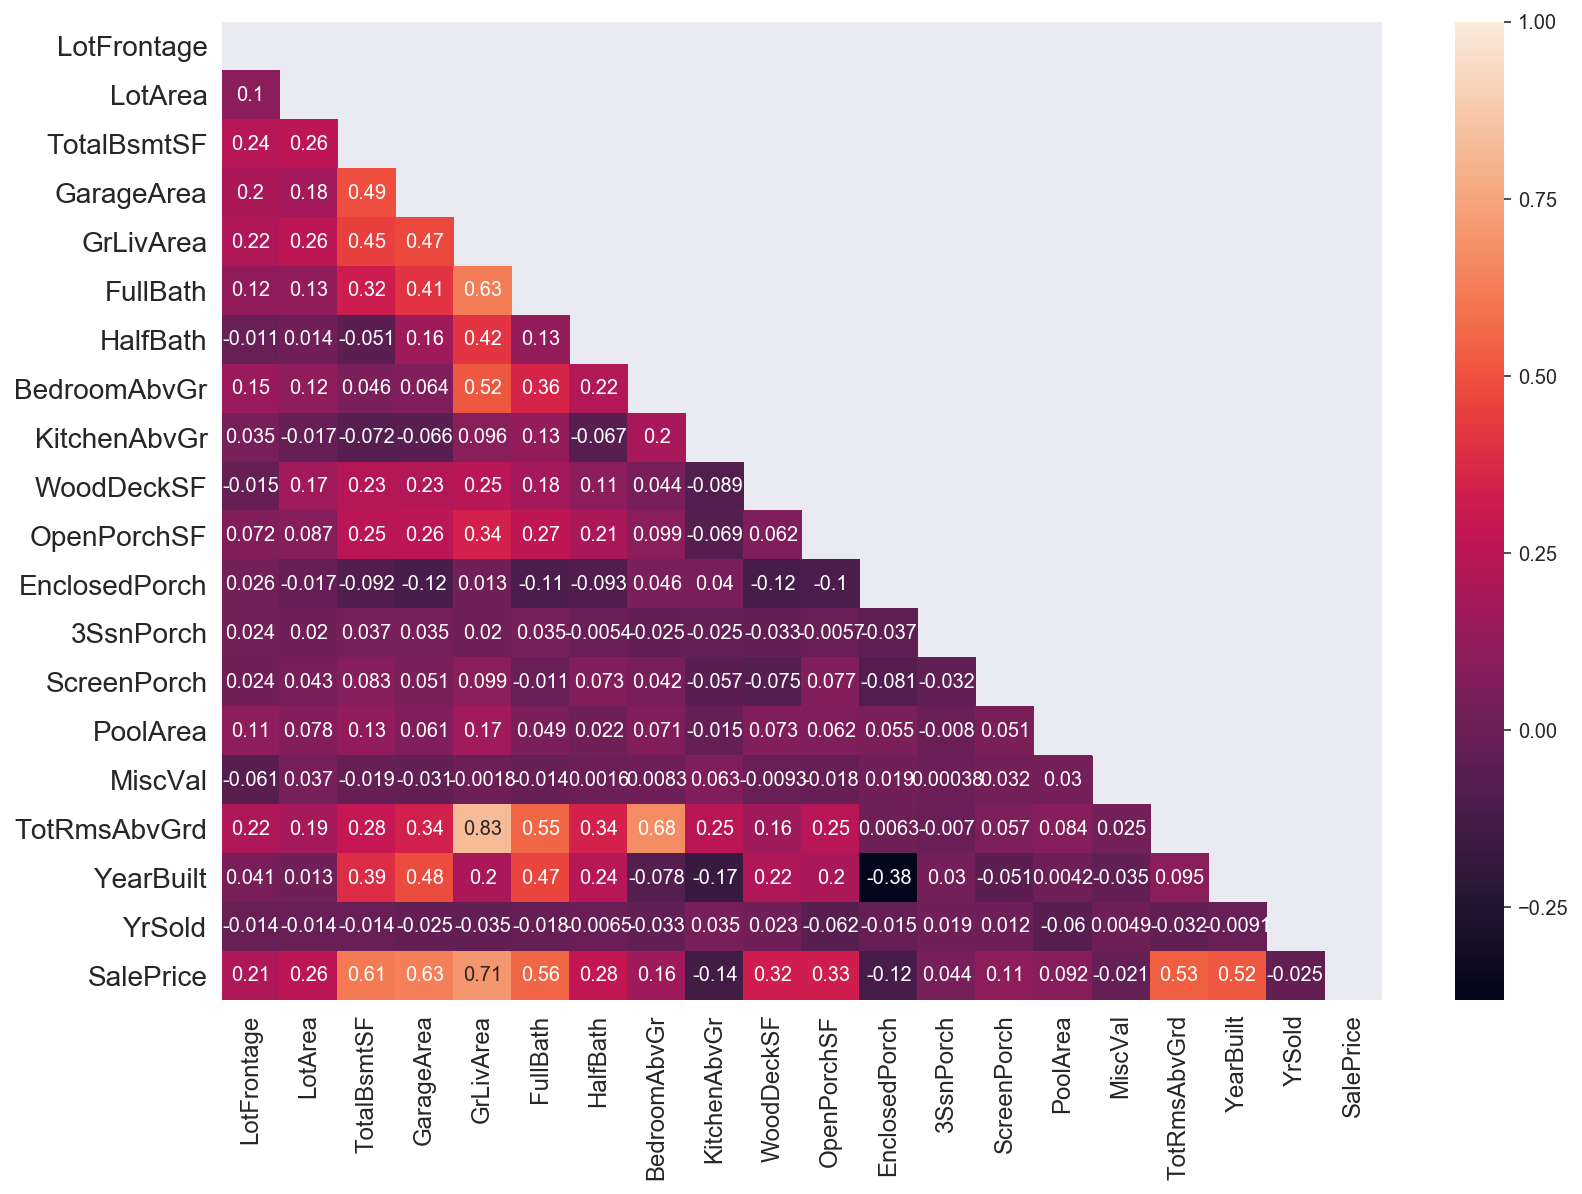

In [32]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(13,9))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

continuous = ['LotFrontage', 'LotArea','TotalBsmtSF','GarageArea','GrLivArea','FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','MiscVal','TotRmsAbvGrd','YearBuilt','YrSold', 'SalePrice']
correlation_heat_map(fixed_house[continuous])

## Look at categorical variables

In [33]:
fixed_house.MSZoning.unique()

array(['RL', 'RM', 'FV', 'RH'], dtype=object)

In [34]:
fixed_house.MSSubClass.unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40], dtype=int64)

In [35]:
### I am coverting the MSSubclass sring to string for dummification
fixed_house.MSSubClass = fixed_house.MSSubClass.astype(str)
fixed_house.MSSubClass.dtypes

C:\Users\Suraj Satheesan\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


dtype('O')

In [36]:
fixed_house.SaleCondition.unique()

array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
      dtype=object)

In [37]:
fixed_house.SaleType.unique()

array(['WD', 'New', 'COD', 'ConLI', 'CWD', 'ConLw', 'Con', 'ConLD', 'Oth'],
      dtype=object)

## Lets make dummies

In [38]:
fixed_house=pd.get_dummies(fixed_house,drop_first=True)


In [39]:
fixed_house.shape

(1450, 73)

In [40]:
fixed_house.head()

,LotFrontage,LotArea,TotalBsmtSF,GarageArea,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,856,548,1710,2,1,3,1,8,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,1262,460,1262,2,0,3,1,6,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,920,608,1786,2,1,3,1,6,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,756,642,1717,1,0,3,1,7,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,1145,836,2198,2,1,4,1,9,...,0,0,0,0,1,0,0,0,1,0


In [41]:
fixed_house.columns

Index(['LotFrontage', 'LotArea', 'TotalBsmtSF', 'GarageArea', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'YearBuilt', 'YrSold',
       'SalePrice', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190',
       'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75',
       'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR2', 'LotShape_IR3',
       'LotShape_Reg', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs',
       'BldgType_TwnhsE', 'HouseStyle_1.5Unf', 'HouseStyle_1Story',
       'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story',
       'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'Fou

In [42]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict

#### Spliting for test and train at YrSold=2010

In [43]:
fixed_be2010=fixed_house[fixed_house.YrSold<2010]

fixed_be2010.isnull().sum()

LotFrontage              0
LotArea                  0
TotalBsmtSF              0
GarageArea               0
GrLivArea                0
FullBath                 0
HalfBath                 0
BedroomAbvGr             0
KitchenAbvGr             0
TotRmsAbvGrd             0
GarageCars               0
WoodDeckSF               0
OpenPorchSF              0
EnclosedPorch            0
3SsnPorch                0
ScreenPorch              0
PoolArea                 0
MiscVal                  0
YearBuilt                0
YrSold                   0
SalePrice                0
MSSubClass_160           0
MSSubClass_180           0
MSSubClass_190           0
MSSubClass_20            0
MSSubClass_30            0
MSSubClass_40            0
MSSubClass_45            0
MSSubClass_50            0
MSSubClass_60            0
                        ..
LandContour_Lvl          0
BldgType_2fmCon          0
BldgType_Duplex          0
BldgType_Twnhs           0
BldgType_TwnhsE          0
HouseStyle_1.5Unf        0
H

In [44]:
fixed_af2010=fixed_house[fixed_house.YrSold>2009]

fixed_af2010.shape

(172, 73)

## Standardize the X variables

In [45]:
#### Creating dependant and independant variables
y=fixed_be2010.SalePrice
X=fixed_be2010.drop('SalePrice',axis=1)

In [46]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [47]:
# X_train,X_valdi,y_train,y_valdi=train_test_split(Xs,y,test_size=0.3,random_state=5)

## Setting up the the test set for post 2010

In [48]:
#### Creating dependant and independant variables
y_test=fixed_af2010.SalePrice
X_test=fixed_af2010.drop('SalePrice',axis=1)

In [49]:
#Standardize the Xtest variables
X_test_s = ss.fit_transform(X_test)

### Linear Regresion Model

In [50]:
lm=LinearRegression()
lm.fit(Xs,y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [51]:
linear_test_error=lm.score(X_test_s, y_test)
linear_train_error=lm.score(Xs, y)

print(lm.score(X_test_s, y_test))
print(lm.score(Xs, y))

0.837482705518439
0.7765233021478074


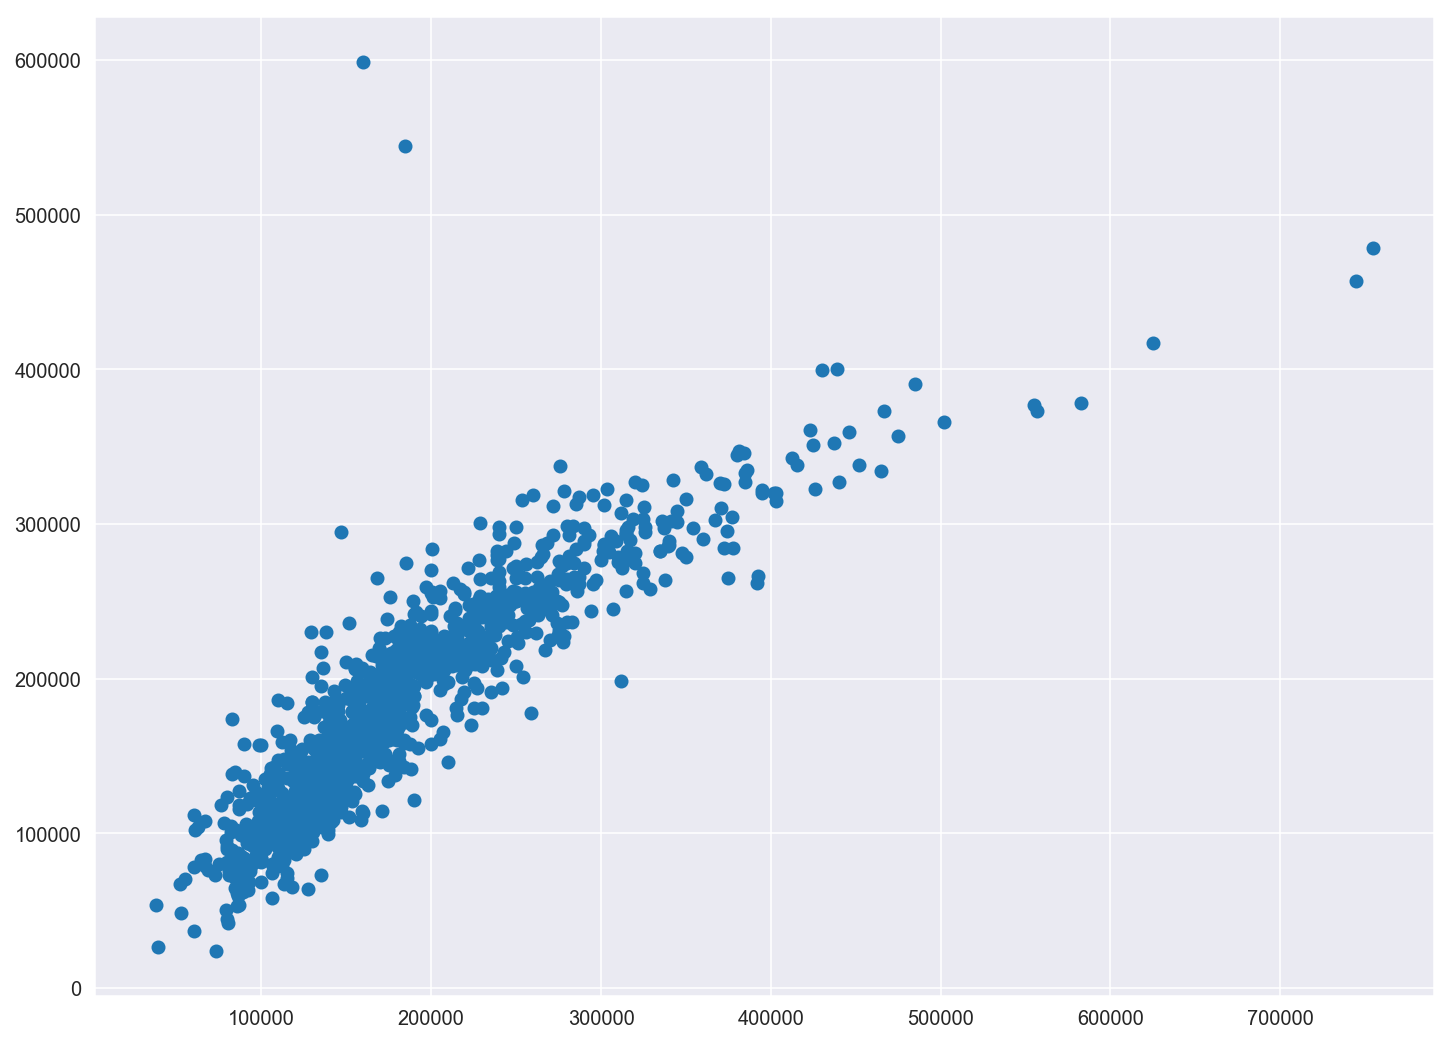

In [52]:
predictions = lm.predict(Xs)
linear_plot=plt.scatter(y, predictions)

In [92]:
#Log
y_log=np.log(y)

In [99]:
lm_log=LinearRegression()
lm_log.fit(Xs,y_log)
lm_log.score(Xs, y_log)

0.8344908348518266

### Ridge Regression

In [53]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs,y)

print(optimal_ridge.alpha_)

162.5755666443795


In [54]:
ridge = Ridge(alpha=optimal_ridge.alpha_)


ridge_scores = cross_val_score(ridge, Xs,y, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.84448503 0.76131873 0.78431821 0.69168812 0.75486214 0.77353071
 0.79003354 0.75270061 0.42518679 0.76929418]
0.73474180731701


In [55]:
ridge.fit(Xs,y)

Ridge(alpha=162.5755666443795, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [56]:
ridge_train_error=ridge.score(Xs,y)
ridge_test_error=ridge.score(X_test_s,y_test)

print('Ridge Train Error:',ridge_train_error)
print('Ridge Test Error:',ridge_test_error)

Ridge Train Error: 0.7661519774513881
Ridge Test Error: 0.8358273408970402


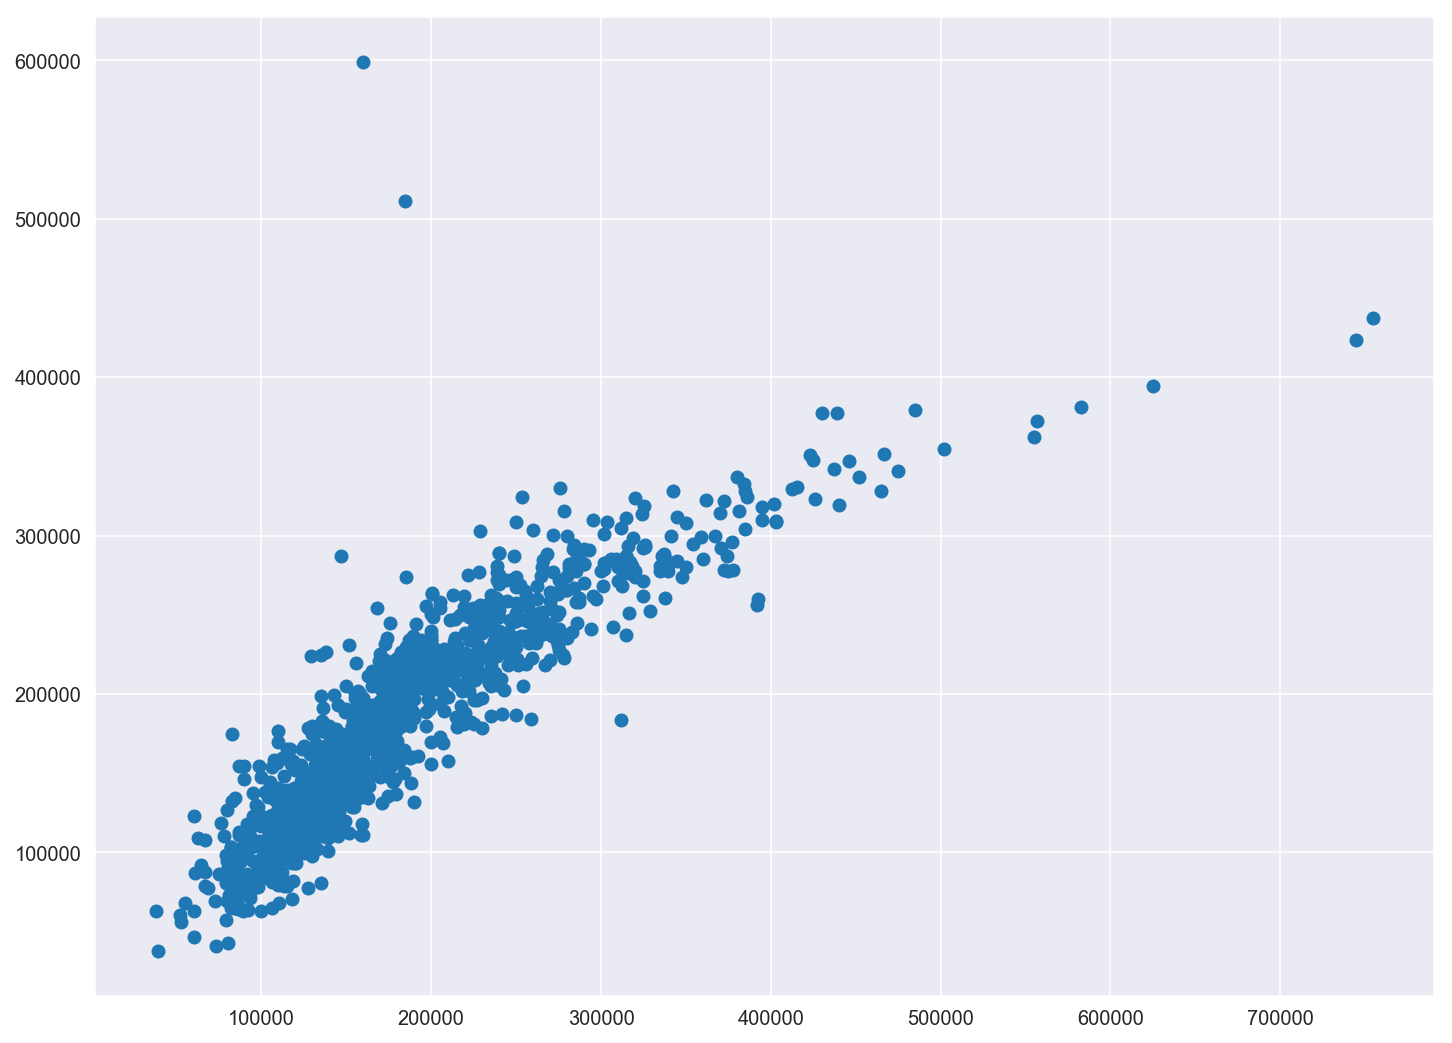

In [57]:
# Make cross validated predictions on the test sets
predictions = ridge.predict(Xs)
plt.scatter(y, predictions)



### Lasso Regression

In [58]:
lasso_alphas = np.logspace(0, 5, 200)

optimal_lasso = LassoCV(alphas=lasso_alphas, cv=10, verbose=1)
optimal_lasso.fit(Xs,y)

print(optimal_lasso.alpha_)

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................C:\Users\Suraj Satheesan\Anaconda3\li

.C:\Users\Suraj Satheesan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
.C:\Users\Suraj Satheesan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
.C:\Users\Suraj Satheesan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
.C:\Users\Suraj Satheesan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objectiv

1644.6761779946644


................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished


In [59]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs,y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.84269015 0.78075053 0.79186913 0.67366449 0.76959082 0.77013577
 0.80356546 0.75389752 0.40389962 0.78705611]
0.7377119612245171


In [60]:
lasso.fit(Xs,y)

Lasso(alpha=1644.6761779946644, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [61]:
lasso_train_error=lasso.score(Xs,y)
lasso_test_error=lasso.score(X_test_s,y_test)

print('Lasso Train Error:',lasso_train_error)
print('Lasso Test Error:',lasso_test_error)



Lasso Train Error: 0.7588771459797465
Lasso Test Error: 0.8204408822764238


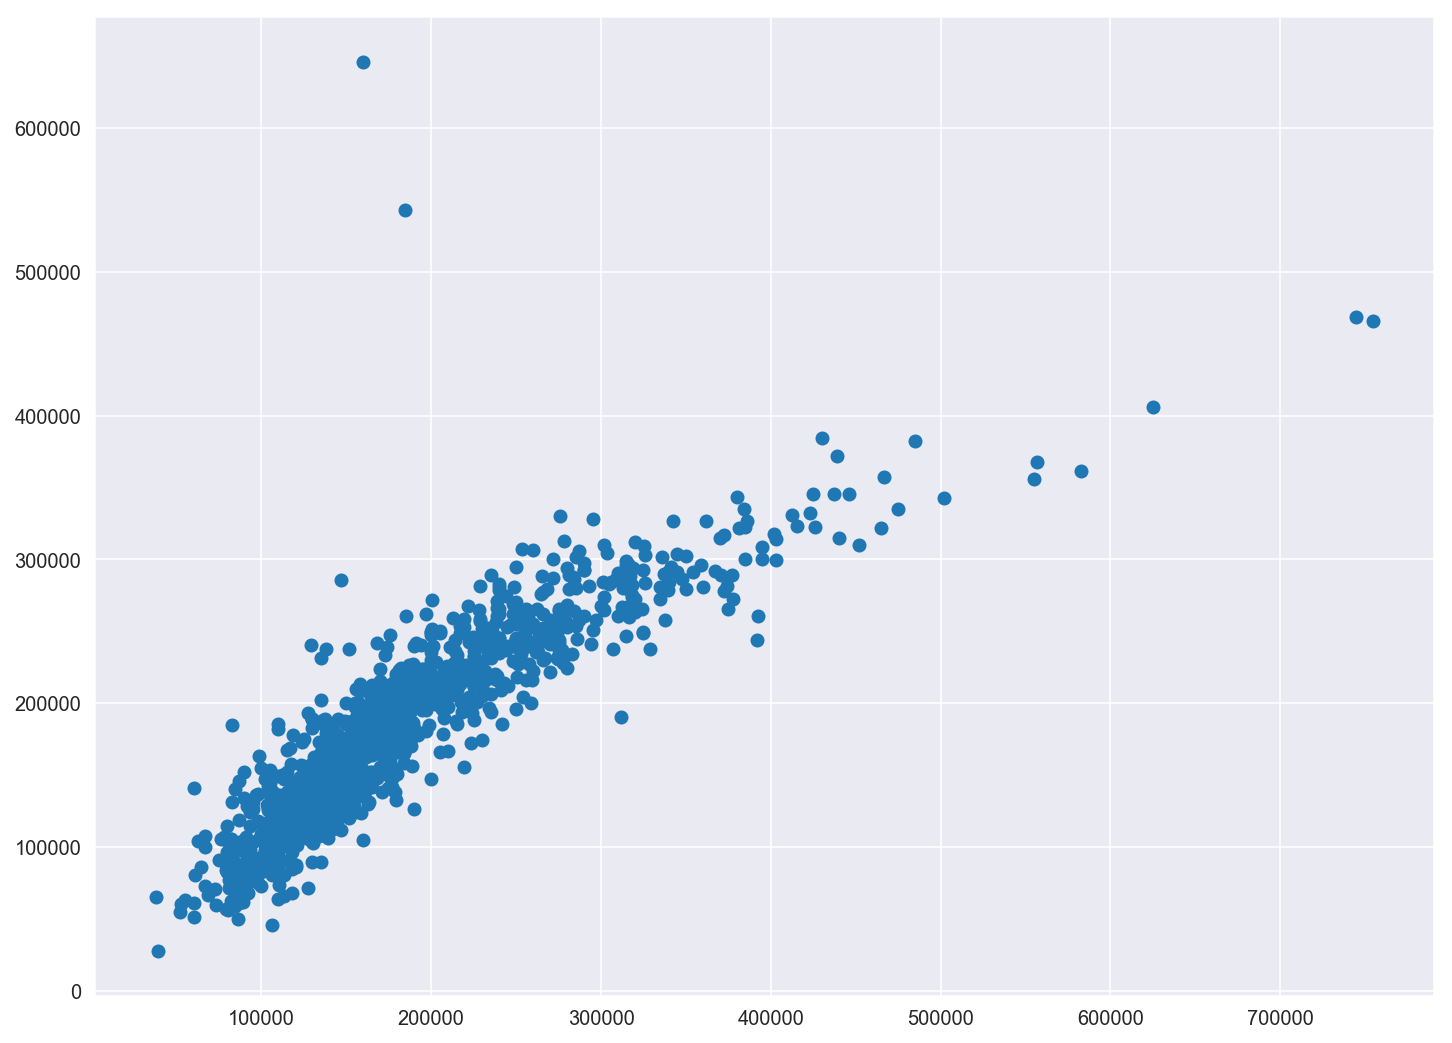

In [62]:
# Make cross validated predictions on the test sets
predictions = lasso.predict(Xs)
plt.scatter(y, predictions)



## Errors from all 3 models

In [63]:
print('LINEAR REGRESSION ERROR')
print('-' * 40)
print('train error: {} | test error: {}\n'.format(linear_train_error, linear_test_error))
print('RIDGE REGRESSION ERROR')
print('-' * 40)
print('train error: {} | test error: {}\n'.format(ridge_train_error, ridge_test_error))
print('LASSO REGRESSION ERROR')
print('-' * 40)
print('train error: {} | test error: {}'.format(lasso_train_error,lasso_test_error))

LINEAR REGRESSION ERROR
----------------------------------------
train error: 0.7765233021478074 | test error: 0.837482705518439

RIDGE REGRESSION ERROR
----------------------------------------
train error: 0.7661519774513881 | test error: 0.8358273408970402

LASSO REGRESSION ERROR
----------------------------------------
train error: 0.7588771459797465 | test error: 0.8204408822764238


In [64]:
# All 3 model faired quite equally with linear regression doing slightly better so I will use this model
# Also noticed that my test error is much better than my train, which could be the result of the train set being
#being larger than the test

In [65]:
linear_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lm.coef_,
                            'abs_coef':np.abs(lm.coef_)})

linear_coefs.sort_values('abs_coef', inplace=True, ascending=False)

linear_coefs.head(20)

,variable,coef,abs_coef
44,BldgType_Duplex,7.729844e+16,7.729844e+16
33,MSSubClass_90,-7.729844e+16,7.729844e+16
4,GrLivArea,4.330734e+04,4.330734e+04
18,YearBuilt,1.569009e+04,1.569009e+04
64,SaleType_New,1.427341e+04,1.427341e+04
10,GarageCars,1.172667e+04,1.172667e+04
7,BedroomAbvGr,-1.070538e+04,1.070538e+04
8,KitchenAbvGr,-1.024328e+04,1.024328e+04
23,MSSubClass_20,9.784024e+03,9.784024e+03
2,TotalBsmtSF,7.394401e+03,7.394401e+03


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### ------------------------------------------------------------------------------------------------------------------------------------------------------
### RESIDUALS PLOT
From above error summary my linear regression model did pretty good job in both train and test. So for residuals vs fitted plot I will use the results from the linear regression

Text(0.5,1,'Residual vs Fitted for training(blue) & test(green)')

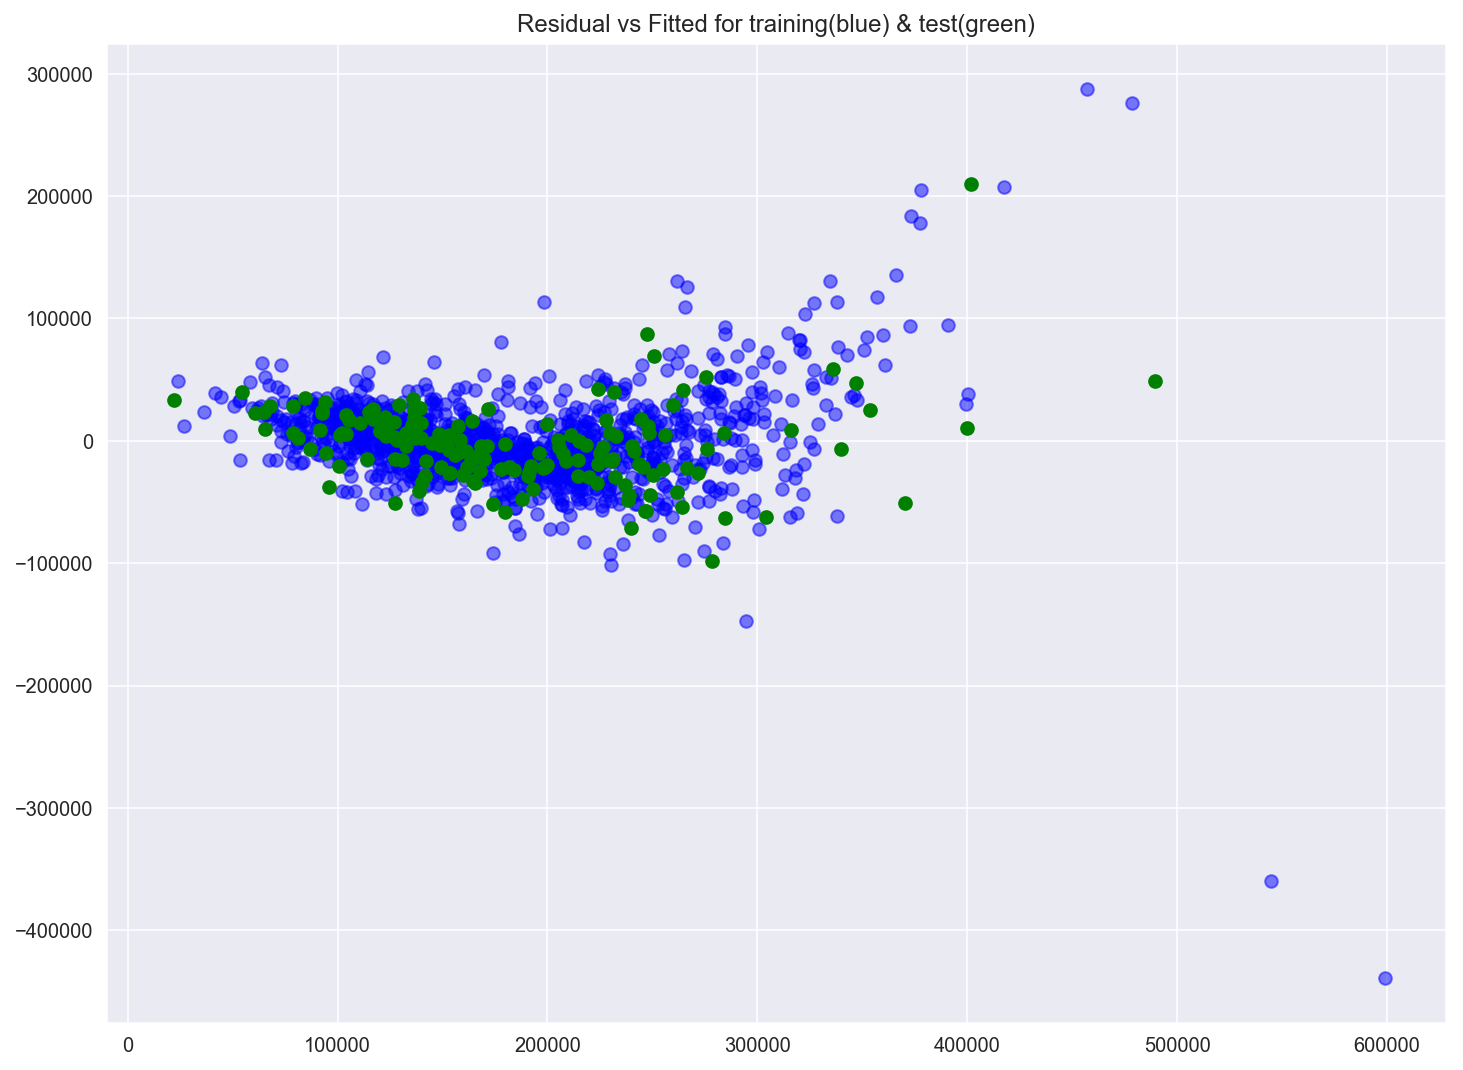

In [66]:
#Getting the predicted values from the linear regression model
y_hat_test=lm.predict(X_test_s)
y_hat_train=lm.predict(Xs)

#Setting up the plotting area size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
#########################################################

plt.scatter(y_hat_train, y-y_hat_train,c='b',s=40,alpha=0.5)
plt.scatter(y_hat_test, y_test-y_hat_test,c='g',s=40)
plt.title('Residual vs Fitted for training(blue) & test(green)')


In [67]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [68]:
#  Here I will make a new dataframe with the renovating features and my target value will be the variance from above model.

# These are the features for the changeable aspects of the house
renov_house=house[['OverallQual', 'OverallCond','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                   'ExterQual', 'ExterCond','BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinType2','Heating','HeatingQC','CentralAir', 'Electrical','KitchenQual','Functional','FireplaceQu',
                   'GarageQual','GarageCond','PavedDrive','PoolQC','Fence']]
renov_house.head()

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,BsmtQual,...,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
0,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,...,Y,SBrkr,Gd,Typ,NaN,TA,TA,Y,NaN,NaN
1,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,Gd,...,Y,SBrkr,TA,Typ,TA,TA,TA,Y,NaN,NaN
2,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,...,Y,SBrkr,Gd,Typ,TA,TA,TA,Y,NaN,NaN
3,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,TA,...,Y,SBrkr,Gd,Typ,Gd,TA,TA,Y,NaN,NaN
4,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,...,Y,SBrkr,Gd,Typ,TA,TA,TA,Y,NaN,NaN


In [69]:
renov_house.shape

(1450, 26)

In [70]:
# Check for null values
print('Any null in the dataframe:',renov_house.isnull().sum().sum()), 
print('-'*90)
renov_house.isnull().sum()

Any null in the dataframe: 3650
------------------------------------------------------------------------------------------


OverallQual        0
OverallCond        0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
ExterQual          0
ExterCond          0
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
KitchenQual        0
Functional         0
FireplaceQu      681
GarageQual        79
GarageCond        79
PavedDrive         0
PoolQC          1443
Fence           1172
dtype: int64

In [71]:
# Taking a look at the unique entries in each column

reno_features=['OverallQual', 'OverallCond','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                   'ExterQual', 'ExterCond','BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinType2','Heating','HeatingQC','CentralAir', 'Electrical','KitchenQual','Functional','FireplaceQu',
                   'GarageQual','GarageCond','PavedDrive','PoolQC','Fence']
for i in renov_house:
    print(i,':',renov_house[i].unique())

OverallQual : [ 7  6  8  5  9  4 10  3  1  2]
OverallCond : [5 8 6 7 4 3 9 2 1]
RoofStyle : ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl : ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st : ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
Exterior2nd : ['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']
MasVnrType : ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
ExterQual : ['Gd' 'TA' 'Ex' 'Fa']
ExterCond : ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual : ['Gd' 'TA' 'Ex' nan 'Fa']
BsmtCond : ['TA' 'Gd' nan 'Fa' 'Po']
BsmtExposure : ['No' 'Gd' 'Mn' 'Av' nan]
BsmtFinType1 : ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
BsmtFinType2 : ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
Heating : ['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor']
HeatingQC : ['Ex' 'Gd' 

In [72]:
# Some columns above are ordinal variables, so we can now rank them numerically.
# Except for OverallQual, OverallCond the remaining will need to be replaced 
# with a ranking numerical value to build the model

In [73]:
# Setting up the the replacement for the ordinal string values
replace_num={'Ex':5,'Gd':4 ,'TA':3,'Fa':2,'Po':1,
             'No':1, 'Gd':4, 'Mn':2 ,'Av':3,np.nan:0,
             'GLQ':6, 'ALQ':5,'BLQ':4,'Rec':3, 'LwQ':2,'Unf':1,
             'Typ':8, 'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1,
             'GdPrv':4,'MnPrv':3, 'GdWo':2 ,'MnWw':1}
# I have assigned the numbers manually by referencing the data dictionary text file             

In [74]:
# Using the applymap function to carry out the coversion
renov_house=renov_house.applymap(lambda x: replace_num.get(x) if x in replace_num else x)

In [75]:
print('Any null in the dataframe:',renov_house.isnull().sum().sum())
print('-'*90)
print('Datatypes in the newly transformed dataframe\n')
print(renov_house.dtypes)

Any null in the dataframe: 0
------------------------------------------------------------------------------------------
Datatypes in the newly transformed dataframe

OverallQual      int64
OverallCond      int64
RoofStyle       object
RoofMatl        object
Exterior1st     object
Exterior2nd     object
MasVnrType      object
ExterQual        int64
ExterCond        int64
BsmtQual         int64
BsmtCond         int64
BsmtExposure     int64
BsmtFinType1     int64
BsmtFinType2     int64
Heating         object
HeatingQC        int64
CentralAir      object
Electrical      object
KitchenQual      int64
Functional       int64
FireplaceQu      int64
GarageQual       int64
GarageCond       int64
PavedDrive      object
PoolQC           int64
Fence            int64
dtype: object


In [76]:
#Making dummy columns for the above non ordinal categories
renov_house=pd.get_dummies(renov_house,drop_first=True)

### Setting up the renovation features with the residuals from the fixed features 

In [77]:
#Here I am making a dataframe for the target, predicted and residuals from my fixed train model
price=pd.DataFrame(y)
price['pred']=lm.predict(Xs)
price['residual']=price.SalePrice-price.pred
price.head()

,SalePrice,pred,residual
0,208500,207791.052097,708.947903
1,181500,176293.171680,5206.828320
2,223500,209737.052097,13762.947903
3,140000,181128.174330,-41128.174330
4,250000,270129.052097,-20129.052097


In [78]:
price.loc[price['pred']>400000]

,SalePrice,pred,residual
58,438780,400366.692681,38413.307319
523,184750,544596.692681,-359846.692681
691,755000,478669.052097,276330.947903
1169,625000,417417.052097,207582.947903
1182,745000,457112.778943,287887.221057
1298,160000,599092.692681,-439092.692681


### Linear Regresion Model for the residuals

In [79]:
#### Creating dependant and independant variables
y_res_train=price.residual
X_res_train=renov_house[renov_house.index.isin(price.index)]

In [80]:
# X_test_s = ss.fit_transform(X_test)

In [81]:
lm_res=LinearRegression()
lm_res.fit(X_res_train,y_res_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [82]:

lm_res.score(X_res_train,y_res_train)


0.3507696400847

In [83]:
#So I have a low R^2 value which could imply that renovation features can't really account for the residuals,
#so I wondered if this would be the same for the residuals from the test set. 

## -----------------------------------------------------------------------------------------------------------------------

In [84]:
#Here I am making a dataframe for the target, predicted and residuals from my fixed test model

price_test=pd.DataFrame(y_test)
price_test['pred']=lm.predict(X_test_s)
price_test['residual']=price_test.SalePrice-price_test.pred
price_test.head()

,SalePrice,pred,residual
16,149000,148086.107605,913.892395
24,154000,139662.107605,14337.892395
26,134800,116984.107605,17815.892395
27,306000,264571.429816,41428.570184
33,165500,190988.107605,-25488.107605


In [85]:
y_res_test=price_test.residual
X_res_test=renov_house[renov_house.index.isin(price_test.index)]

lm_res_tes=LinearRegression()
lm_res_tes.fit(X_res_test,y_res_test)

lm_res_tes.score(X_res_test,y_res_test)

0.4554298508817641

### Residuals prediction errors

In [86]:
print('LINEAR REGRESSION ERROR for RESIDUALS')
print('-' * 40)
print('residual from train error: {} | residual from test error: {}\n'.format(lm_res.score(X_res_train,y_res_train),lm_res_tes.score(X_res_test,y_res_test)))

LINEAR REGRESSION ERROR for RESIDUALS
----------------------------------------
residual from train error: 0.3507696400847 | residual from test error: 0.4554298508817641



In [87]:
#The renovatable features could only account for 35% of the residuals
#I think the model can be improved further by maybe finding a different way to rank the ordinal categories.
#Also look into droping some datapoints that may not be a good representation of the entire dataset try running the model
#again.

In [101]:
renov_house.shape

(1450, 75)

In [100]:
fixed_house.shape

(1450, 73)

In [103]:
full_house=pd.merge(fixed_house,renov_house,left_index=True,right_index=True)
full_house.shape

(1450, 148)

In [104]:
full_be2010=full_house[full_house.YrSold<2010]
full_af2010=full_house[full_house.YrSold>2010]

In [105]:
X_full=full_be2010=full_house[full_house.YrSold<2010]

In [106]:
lmfull_log=LinearRegression()
lmfull_log.fit(X_full,y_log)
lmfull_log.score(X_full, y_log)

0.9677231841290418

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [88]:
# A: